# Задание 1
## Генерация точек

In [380]:
import numpy as np
from scipy.stats import norm, uniform, randint
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline


def get_sample(n=2, size=1000, is_separable=True):
    center = [np.array([1] * n), np.array([-1] * n)]
    
    var = 0.01
    if not is_separable:
        var = 1 / var
    
    points = []
    for i in range(size):
        c = randint.rvs(0, 2)
        
        points.append(np.array([c, -1] + list(center[c] + norm.rvs(scale=var ** 0.5, size=n))))
    
    return np.array(points)


def get_equation(omega):
    return lambda x: np.sum(x * omega[1:]) - omega[0]


def get_a(omega):
    return np.array([-omega[2], omega[1]])


def get_points_2(omega, var=10):
    point = omega[0] * omega[1:]
    points = [point - var * get_a(omega), point + var * get_a(omega)]
    return np.array(points)


def get_uniform_sample(n=2, size=1000, is_separable=True, eps=1e-2):
    x = np.array([uniform.rvs(loc=-1, scale=n, size=size) for i in range(n)])
    
    c = [0] * size
    
    if not is_separable:
        c = randint.rvs(0, 2, size=size)
    else:
        omega = np.array([0] + list(uniform.rvs(loc=-1, scale=2, size=n)))
        equation = get_equation(omega)
        for i in range(size):
            if equation(np.array(x[:, i])) > eps:
                c[i] = 0
            elif equation(np.array(x[:, i])) < -eps:
                c[i] = 1
            else:
                c[i] = 2
    
    return np.array(list(filter(lambda x: x[0] != 2, list(zip(c, [-1] * size, *x)))))


def print_sample_2(sample):
    class_0 = np.array(list(filter(lambda x: x[0] == 0, sample)))
    class_1 = np.array(list(filter(lambda x: x[0] == 1, sample)))
    
    if len(class_0):
        plt.plot(class_0[:, 2], class_0[:, 3], 'ob', ms=3, alpha=0.3)
    
    if len(class_1):
        plt.plot(class_1[:, 2], class_1[:, 3], 'or', ms=3, alpha=0.5)
        

def print_line_2(omega, line_par=2):
    omega = omega / (omega[1] ** 2 + omega[2] ** 2) ** 0.5
    equation = get_equation(omega)
    
    points = get_points_2(omega, line_par)
    plt.plot(points.T[0], points.T[1], 'g')

In [381]:
separable_sample = get_sample(size=1000, is_separable=True)
nseparable_sample = get_sample(size=1000, is_separable=False)
uniform_separable_sample = get_uniform_sample(is_separable=True)
uniform_nseparable_sample = get_uniform_sample(is_separable=False)

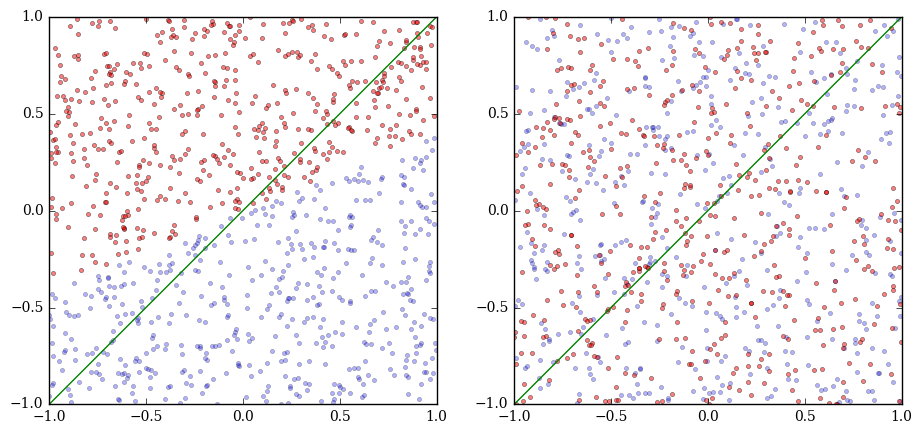

In [382]:
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
print_sample_2(uniform_separable_sample)
print_line_2(np.array([0, -1, 1]), line_par=1.5)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.subplot(1, 2, 2)
print_sample_2(uniform_nseparable_sample)
print_line_2(np.array([0, -1, 1]))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.show()

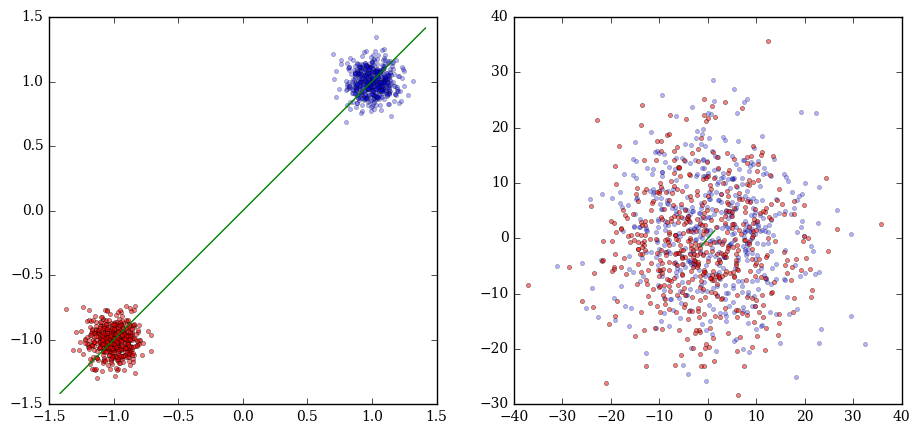

In [383]:
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
print_sample_2(separable_sample)
print_line_2(np.array([0, -1, 1]))

plt.subplot(1, 2, 2)
print_sample_2(nseparable_sample)
print_line_2(np.array([0, -1, 1]))

plt.show()

## Градиентный спуск

In [403]:
default_t = lambda t, k, x: t * 0.98


def project(x):
    return x / np.sqrt((x * x).sum())


def vect_abs(x):
    return np.sqrt((x * x).sum())

# Нахождение миниумума методом градиентного спуска
def find_min(x_0, f, grad, next_t=default_t, eps=1e-6, MAX_K = 1000, use_projection=False):
    t = 0.5
    old_x = project(x_0)
    k = 0
    
    while True:
        k += 1
        t = next_t(t, k, old_x)
        x = old_x - t * grad(old_x)
        
        if use_projection and vect_abs(x) > 1:
            x = project(x)
        
        if (np.abs(f(x) - f(old_x)) < eps) or k == MAX_K:
            old_x = x
            break
        
        old_x = x
    
    return (old_x, k)

### Формулировка для разделяющей гиперплоскости
$\omega$ - уравнение плоскости (нулевую координату имеет свободный член), $x$ - точка с дополнительной нулевой координатой со значением $-1$. Утверждается, что точка минимума функции риска $Q(\omega) = \sum_{i=1}^{m} ln(1 + exp(-y_i \cdot <x_i, \omega>))$ есть искомая разделяющая прямая ($y_i$ - соответствующий класс точки).

$\frac{\delta Q}{\delta {\omega_i}} = \sum_{i=1}^{m} (1 - \frac{1}{1 + exp(-y_i \cdot <x_i, \omega>)}) \cdot (-y_i x_{i}^{k})$

In [404]:
def get_class(c):
    if c:
        return 1
    return -1


def raw_grad(omega, X, Y):
    return np.sum((1 - expit(Y * np.sum(X * omega, axis=1))) * (-Y * X.T), axis=1)

    
def get_grad(X, Y):
    return lambda omega: raw_grad(omega, X, Y)

    
def raw_fun(X, Y, omega):
    return np.sum(np.logaddexp(0, -Y * np.sum(X * omega, axis=1)))


def get_fun(X, Y):
    return lambda omega: raw_fun(X, Y, omega)


def get_xy(sample):
    return sample[:, 1:], np.array([get_class(y[0]) for y in sample])

In [405]:
def test_gradient_2(sample, x0, next_t=default_t, max_k=10000, use_projection=False, 
                    x_lim=2, y_lim=2, line_par=100):

    X, Y = get_xy(sample)

    omega, k = find_min(x0, get_fun(X, Y), get_grad(X, Y), MAX_K=max_k, use_projection=use_projection)
    
    print(omega, k)
    
    omega = omega / (omega[1] ** 2 + omega[2] ** 2) ** 0.5
    equation = get_equation(omega)

    plt.figure(figsize=(12, 8))
    print_sample_2(sample)
    points = get_points_2(omega, line_par)
    plt.plot(points.T[0], points.T[1], 'g')

    plt.xlim(-x_lim, x_lim)
    plt.ylim(-y_lim, y_lim)
    plt.show()

[  -2.86935396 -245.02378034 -245.36647943] 2


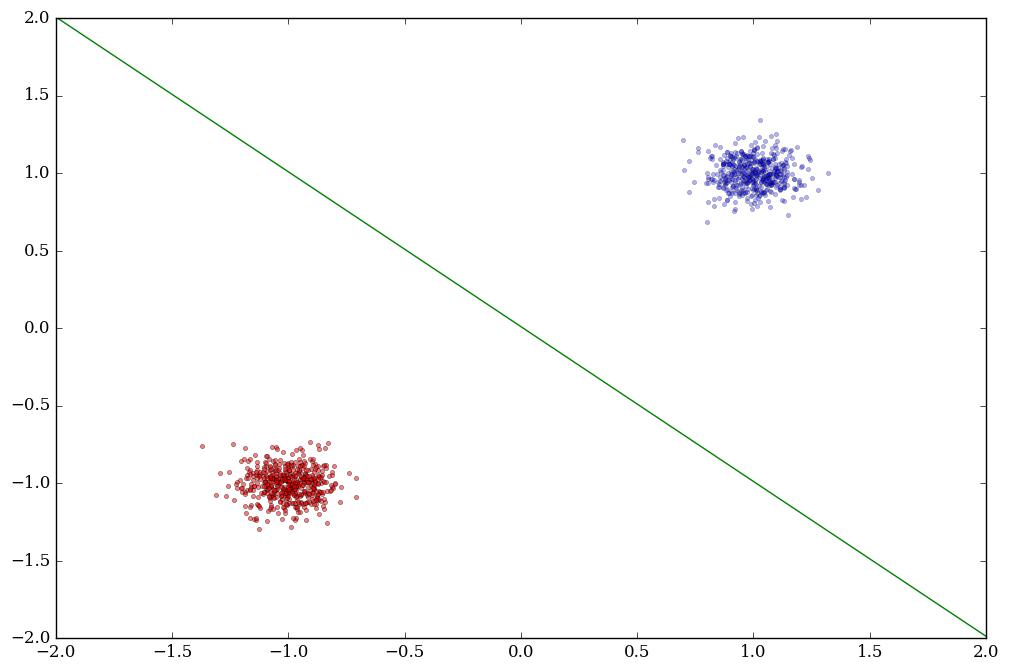

In [406]:
test_gradient_2(separable_sample, np.array([0, -1, 1]), use_projection=False)

[-0.02181676 -0.02392207 -0.02359634] 683


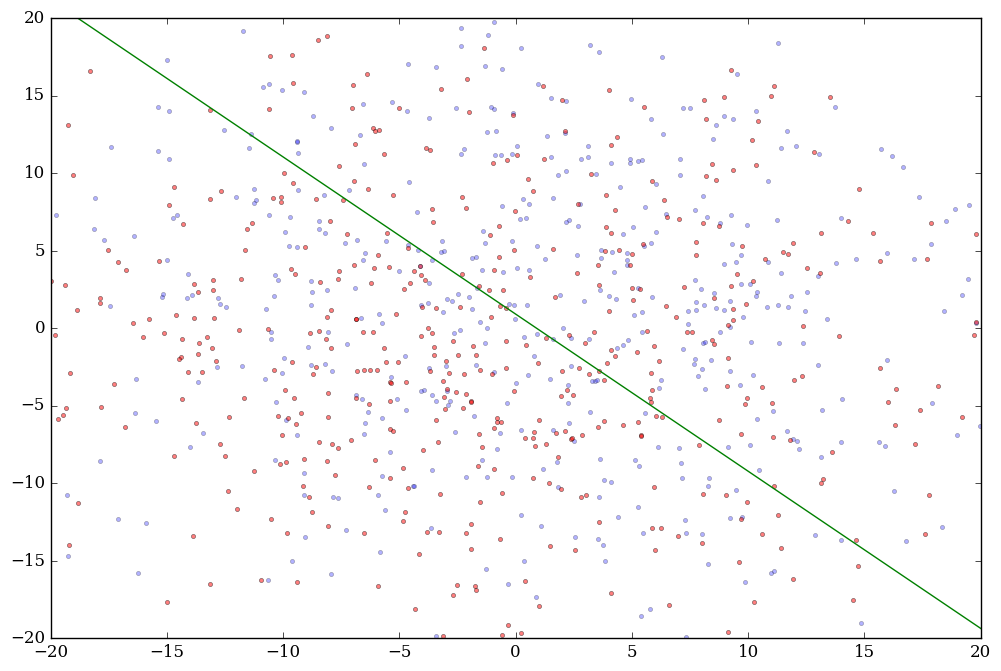

In [407]:
test_gradient_2(nseparable_sample, np.array([0, -1, 1]), x_lim=20, y_lim=20)

[  -0.21576265  -59.35697036  145.8797259 ] 291


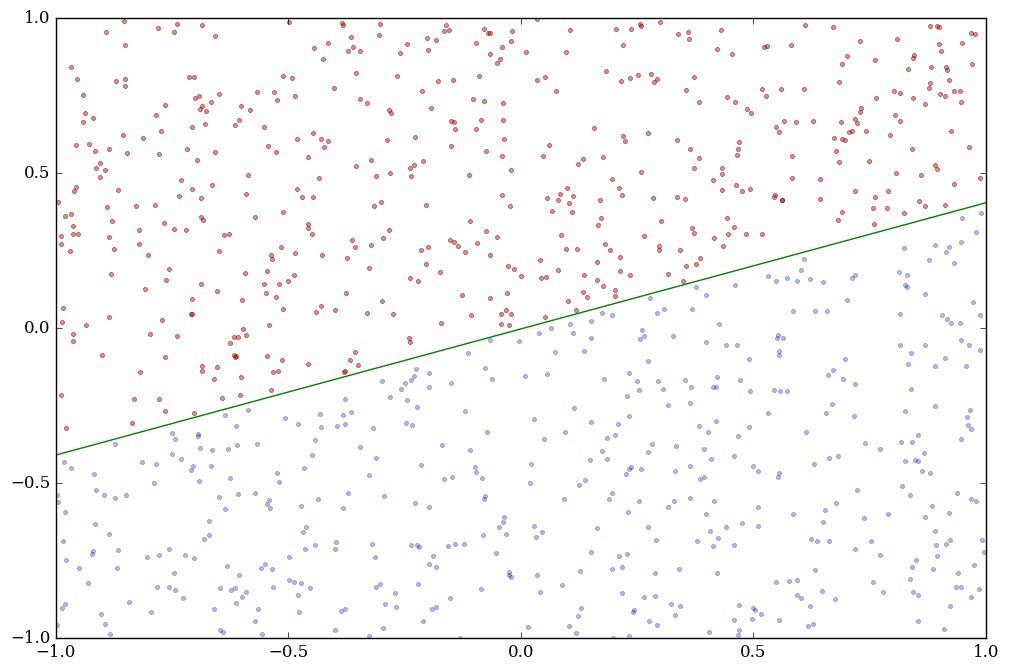

In [408]:
test_gradient_2(uniform_separable_sample, np.array([0, -1, 1]), x_lim=1, y_lim=1, 
                max_k=20000)

### Количество шагов от точности.
Применяются две стратегии выбора шага:

1. $t_k = t_{k - 1} \cdot 0.98$

2. $t_k = \frac{1}{\sqrt{k + 1}}$

In [414]:
plt.rc('font', family='serif', size="12")


def test_t(x0, sample, next_t, label):
    X, Y = get_xy(sample)
    
    K = []
    N = 15
    for i in range(1, N + 1):
        omega, k = find_min(x0, get_fun(X, Y), get_grad(X, Y), MAX_K=100000, 
                            eps=10 ** (-i), next_t=next_t)

        K.append(k)
        if (k > 10000):
            break
    
    plt.plot(range(1, N + 1), K + [K[-1]] * (N - len(K)), label=label)
    
    
def test(x0, sample):
    plt.figure(figsize=(10, 5))
    test_t(x0, sample, lambda t, k, x: 1 / np.sqrt(k + 1), r'$t_k = \frac{1}{\sqrt{k + 1}}$')
    test_t(x0, sample, lambda t, k, x: t * 0.98, r'$t_k = t_{k - 1} \cdot 0.98$')

    plt.legend(loc='upper left')
    plt.ylabel(r'$N$')
    plt.ylim(0, 5000)
    plt.xlim(1, 15)
    plt.xlabel(r'$log(\frac{1}{\varepsilon})$')
    plt.show()

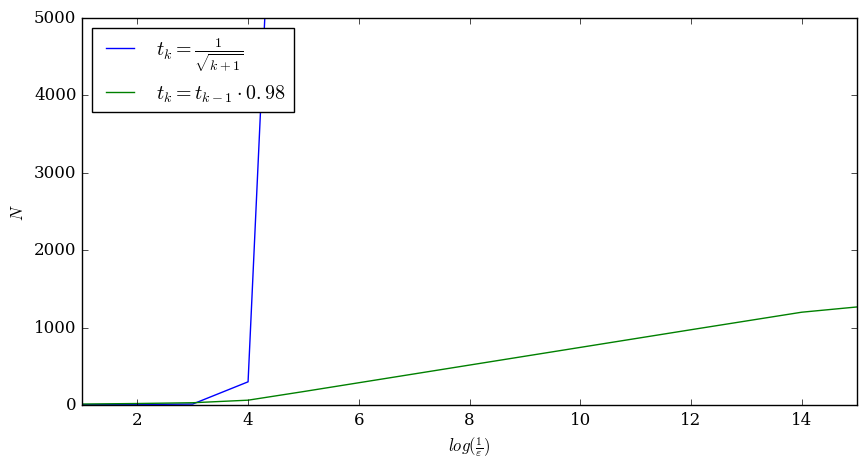

In [415]:
# n = 2
test(np.array([0.001, -1, 1]), uniform_separable_sample)

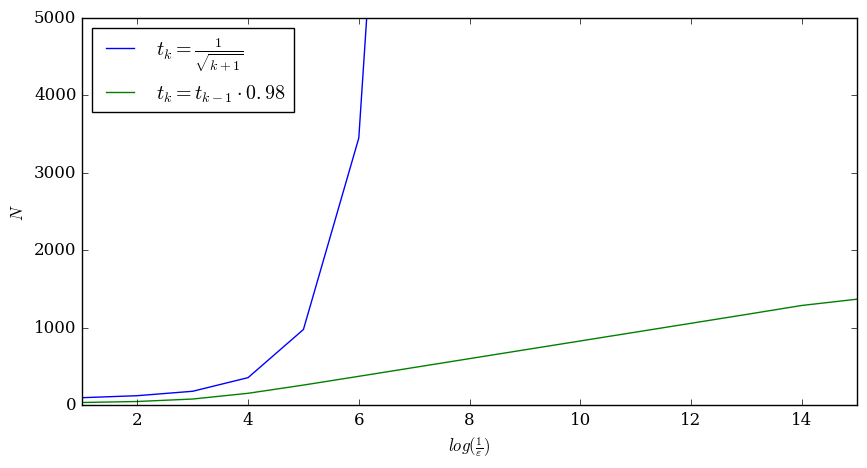

In [416]:
# n = 3
uniform_separable_sample_3 = get_uniform_sample(n=3)
test(np.array([0.001, -1, 1, 1]), uniform_separable_sample_3)

Видно, что у 2 метода скорость сходимости линейная (от логарифма), а вот в случае 1 очевидна не менее, чем экспоненциальная